In [179]:

# This is basically all you need for numerics:
import numpy as np
import scipy as sp

# Initializing a random seed:
rng = np.random.default_rng(seed=1234)

# These are some plotting packages:
## Basic plotting
import matplotlib.pyplot as plt
## Intermediate plotting
import seaborn as sns

# This is kinda nice to have
from tqdm.notebook import tqdm

In [224]:
def round(v, eigenvec_abs, conditioning):
  """
  Rounds the output vector to match the magnitude assumptions.
  I made this as hard as possible the first time:
    # if np.abs((v[i] - eigenvec_abs[i])) < np.abs((v[i] + eigenvec_abs[i])):
    #   v[i] = eigenvec_abs[i]
    # else:
    #   v[i] = -eigenvec_abs[i]
  """
  if (conditioning):
    return np.sign(v)
  
  v = np.sign(v) * eigenvec_abs
    
  return v

In [225]:
# This is one way to generate a problem, Idk if its the best way to make these 
# problems (our choice of how to do this matters)
class Big_matrix:
  def __init__(self, matrix):
    self.__matrix = matrix

  def get_row(self, i):
    return self.__matrix[i]
 #would also work as [i, :]? YES

  def get_col(self, i):
    return self.__matrix[:, i]
  


def generate_problem(d: int, k: int):


  """
  Returns a eigenvector phase retrieval problem:
    - a Big_matrix instance
    - an eigenvalue of the instance
    - the absolute value of the entries of the eigenvector of that eigenvalue
  """
  #d is size of matrix, k is which eigenvector we want from the array of eigenvectors
  #in our model, this is harder when k is closer to d/2, k = 0 or k = d is easiest
  assert k < d
  #not <= bc of 0 indexing

  A = rng.normal(size=(d, d))
  S = A + A.T

  #S.T = A.T + A = S
  #this way eigenvalues are real
  #so now S is symmetric

  big_matrix = Big_matrix(S)
  w, V = np.linalg.eig(S)
  v_abs = np.abs(V[:, k])
  ell = w[k]
  epsilon = np.sign(V[:, k])

  B = S - ell * np.eye(d)

  v_init = rng.normal(size=d)

  return v_init, big_matrix, ell, v_abs, epsilon


  


In [226]:
def project(v, w):
  """
  This function should return the projection of `v` onto the span of `w`.
  """
  r = np.dot(v, w)/(np.dot(w, w)) * w

  return r

In [227]:
def project_onto_orthogonal_subspace(v, w):
  return v - project(v, w)

In [228]:
def K_step(eigenvec_abs, v, ell, M, i, conditioning):
  """
  Returns the projection of `v` onto the orthogonal space of the the `i`th row
  of B (or C if conditioning is on)
  ell (l) is the eigenvalue
  """
  d = len(v)
  i = i%d
  #i = np.choice(d) makes it random
  w = M.get_row(i)-(ell*((np.eye(d))[i, :]))

  if conditioning: 
    B_row_i = w
    B_row_i = w * eigenvec_abs / eigenvec_abs[i]
    w = B_row_i


  v = project_onto_orthogonal_subspace(v, w)

  return v

In [229]:
def K_algorithm(v_init, M, ell, eigenvec_abs, epsilon, n_iter, rounding_freq, conditioning):
  """
  Applies the K. algorithm to the initial vector `v_init` with the `Big_matrix`
  for `n_iter` steps.
  """
  v = v_init
  #tqdm is a progress bar
  #np.arange basically range creates list of 0 - 9 (if n_iter is 10)
  """
  Trying to add a step count + regular rounding and if the score = 1.0, break the loop and return how many steps it took
  THIS BREAKS IT SOMEHOW
  """

  for i in np.arange(n_iter):
    v = K_step(eigenvec_abs, v, ell, M, i, conditioning)
    #we check if we're finished every 10 steps
    if i%10 == 0:
      if score(v, epsilon) == 1.0: 
        return v, i
    #every rounding_freq steps we round (-1 turns off rounding altogether)
    if (rounding_freq >= 0):
      if i%(int(rounding_freq*n_iter)) == 0:
        v = round(v, eigenvec_abs, conditioning)  
  v = round(v, eigenvec_abs, conditioning)    

  return v, n_iter




  

In [247]:
def score(v_current, epsilon):
  size = len(v_current)
  #why does this break it sometimes?
  assert size == len(epsilon)
  test_epsilon = np.sign(v_current)
  score = 0
  for i in range(size):
    if test_epsilon[i] == epsilon[i]:
      score += 1
  if score < (size / 2):
    score = size - score
  return score / size


^^^THEIR ALGORITHM(ISH)^^^

In [248]:
def big_test(d, k, n_iter, x, rounding_freq, conditioning):

  sum = 0
  unfinished = 0
  steps_taken_list = []
  #run x amount of times
  for i in range(x):
    v_init, M, ell, eigenvec_abs, epsilon = generate_problem(d, k)
    v, steps_taken = K_algorithm(v_init, M, ell, eigenvec_abs, epsilon, n_iter, rounding_freq, conditioning)
    steps_taken_list.append(steps_taken)
    if (steps_taken==n_iter):
      unfinished += 1
      #print unfinished runs
      #print(v, score(v, epsilon), stepsTaken)
  avg = np.mean(steps_taken_list)
  unfinished = unfinished/x * 100
  print("avg steps", avg)
  print("unfinished", unfinished, "%")
  return steps_taken_list, unfinished

In [249]:
#RUN A BUNCH OF BIG TESTS DIFF ROUNDING FREQ
d, k = 20, 2
n_iter = 1000
x = 500
#run x amount of times
conditioning = False
freq_to_test = [-1, 0.1, 0.2, 0.5, 1]

for i in range(len(freq_to_test)):
  print("freq", freq_to_test[i])
  big_test(d, k, n_iter, x, freq_to_test[i], False)
  print("WITH CONDITIONING")
  big_test(d, k, n_iter, x, freq_to_test[i], True)
  print("")

freq -1
avg steps 881.64
unfinished 74.8 %
WITH CONDITIONING
avg steps 936.1
unfinished 89.2 %

freq 0.1
avg steps 445.02
unfinished 27.200000000000003 %
WITH CONDITIONING
avg steps 941.8
unfinished 92.60000000000001 %

freq 0.2
avg steps 483.68
unfinished 16.6 %
WITH CONDITIONING
avg steps 919.42
unfinished 87.2 %

freq 0.5
avg steps 658.68
unfinished 36.199999999999996 %
WITH CONDITIONING
avg steps 926.48
unfinished 85.2 %

freq 1
avg steps 799.32
unfinished 63.4 %
WITH CONDITIONING
avg steps 930.44
unfinished 87.4 %



avg steps 374.9
unfinished 17.0 %


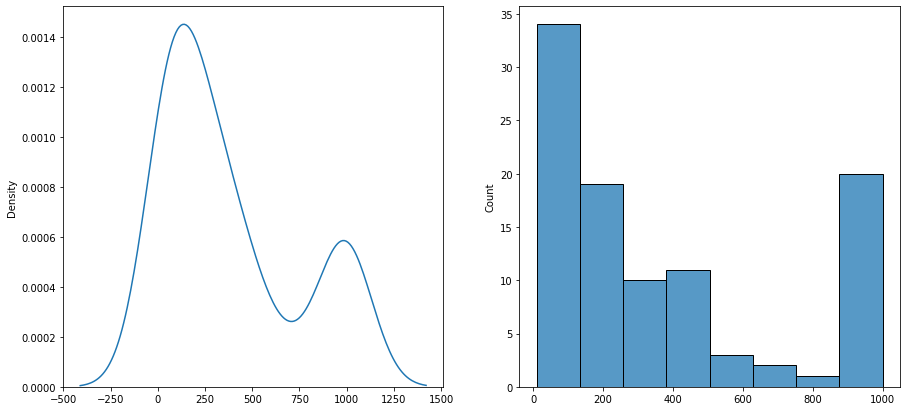

In [246]:
#run one big test
d, k = 10, 2
n_iter = 1000
x = 100
#run x amount of times
conditioning = False
rounding_freq = -1
steps_taken_list, num_unfinished = big_test(d, k, n_iter, x, rounding_freq, conditioning)


fig, ax = plt.subplots(1, 2, figsize=(15,7))
#make a 1 by 2 array of axis, put them in the fig object (of size 10 x 5 inches? pixels? )
#ax is the list of axis

#rounding is what gets you stuck in loops!!

sns.kdeplot(x=steps_taken_list, ax=ax[0])
sns.histplot(x=steps_taken_list, ax=ax[1])


 



#QUESTIONS:
CONDITIONING???

#THINGS TO IMPLEMENT
randomly picking rows

making rounding a probability instead of modulo

randomness in general helps us get stuck in a loop (for the runs that just don't finish)




#IDEAS:
Matrix Conditioning

Adding noise per vector projection 

Rounding freq
  - making it a probability instead of %

Normalize vectors on each step

Adaptive rounding?
  - if you've moved a small amount, probability to round is smaller
     - measure distance projected norm of distance between new and old vector
  - we only round if it brings us to a novel sign vector
Projecting somewhere else onto the orthogonal subspace instead of the shortest possible path



In [195]:

""

''